<a href="https://colab.research.google.com/github/Affiwhizz/nlp-project-automated-reviews/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
# Install
!pip install -q transformers datasets evaluate accelerate

from google.colab import drive
from pathlib import Path

# Python & Data Handling
import os
import gzip
import json
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Hugging Face Transformers (Classification & Summarization) ---
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    pipeline
)

# Evaluation
import evaluate

# NLP Preprocessing
import re
import string

# For summarization
from transformers import AutoModelForSeq2SeqLM, BartTokenizer, BartForConditionalGeneration

# Deployment / Export
import io
import gradio as gr
import math


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.3 MB/s eta 0:00:00


# Data Loading

In [2]:
!mkdir -p data/amazon_electronics
%cd /content/data/amazon_electronics

# Reviews
!wget -nc http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Electronics_5.json.gz

# Meta
!wget -nc http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/meta_Electronics.json.gz

%cd /content

# Check
!ls -lh data/amazon_electronics

/content/data/amazon_electronics
--2025-09-30 17:07:34--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Electronics_5.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 495854086 (473M) [application/x-gzip]
Saving to: ‘reviews_Electronics_5.json.gz’

reviews_Electronics 100%[===================>] 472.88M  31.6MB/s    in 8.7s    

2025-09-30 17:07:43 (54.6 MB/s) - ‘reviews_Electronics_5.json.gz’ saved [495854086/495854086]

--2025-09-30 17:07:43--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/meta_Electronics.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 186594679 (178M) [application/x-gzip]
Saving to: ‘meta_Electronics.json.

# Data Inspection

In [3]:
def load_gz_jsonlines(path, max_rows=None):
    rows = []
    with gzip.open(path, "rt", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if max_rows is not None and i >= max_rows:
                break
            rows.append(json.loads(line))
    return pd.DataFrame(rows)

REV_PATH  = "/content/data/amazon_electronics/reviews_Electronics_5.json.gz"
META_PATH = "/content/data/amazon_electronics/meta_Electronics.json.gz"

MAX_ROWS = 120_000
df_raw   = load_gz_jsonlines(REV_PATH, max_rows=MAX_ROWS)

print("Shape:", df_raw.shape)
print("Columns:", df_raw.columns.tolist())
df_raw.head(3)

Shape: (120000, 9)
Columns: ['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText', 'overall', 'summary', 'unixReviewTime', 'reviewTime']


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5.0,Gotta have GPS!,1370131200,"06 2, 2013"
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1.0,Very Disappointed,1290643200,"11 25, 2010"
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3.0,1st impression,1283990400,"09 9, 2010"


# **Task 1(Data Preprocessing)**

In [4]:
# Classification Prep

rating_col = "overall"      # 1–5 stars
text_col   = "reviewText"   # main review text
pid_col    = "asin"         # product id
title_col  = "summary"      # Title

def star_to_label(x):
    if x in (1, 2): return "Negative"
    if x == 3:      return "Neutral"
    if x in (4, 5): return "Positive"
    return None

df = df_raw[[rating_col, text_col, title_col, pid_col]].copy()

# Map stars to sentiment label
df["label"] = df[rating_col].apply(star_to_label)

# Drop rows with missing text or label
df = df.dropna(subset=[text_col, "label"]).reset_index(drop=True)

print("After cleaning:", df.shape)
df[["label"]].value_counts()

After cleaning: (120000, 5)


,count
label,
Positive,97315
Negative,13339
Neutral,9346


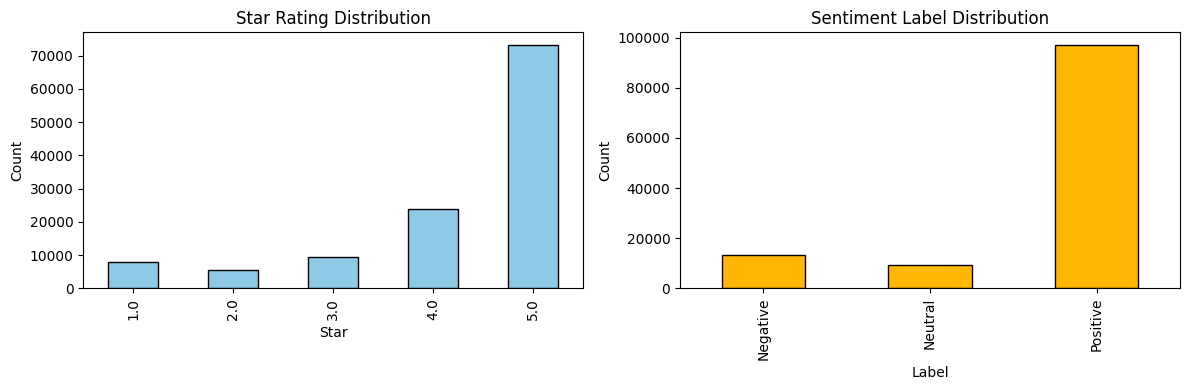

In [7]:
# Checking star + label distributions
fig, axes = plt.subplots(1, 2, figsize=(12,4))
df[rating_col].value_counts().sort_index().plot(kind="bar", ax=axes[0], color="#8ecae6", edgecolor="black")
axes[0].set_title("Star Rating Distribution"); axes[0].set_xlabel("Star"); axes[0].set_ylabel("Count")

df["label"].value_counts().reindex(["Negative","Neutral","Positive"]).plot(kind="bar", ax=axes[1], color="#ffb703", edgecolor="black")
axes[1].set_title("Sentiment Label Distribution"); axes[1].set_xlabel("Label"); axes[1].set_ylabel("Count")

plt.tight_layout(); plt.show()

In [5]:
# Class balancing
RANDOM_STATE = 42
target_per_class = 2000

balanced_parts = []
for cls in ["Negative", "Neutral", "Positive"]:
    cls_df = df[df["label"] == cls]
    take_n = min(target_per_class, len(cls_df))
    balanced_parts.append(cls_df.sample(n=take_n, random_state=RANDOM_STATE))

df_bal = (
    pd.concat(balanced_parts, axis=0)
      .sample(frac=1, random_state=RANDOM_STATE)
      .reset_index(drop=True)
)

print("Balanced shape:", df_bal.shape)
print(df_bal["label"].value_counts())

Balanced shape: (6000, 5)
label
Negative    2000
Neutral     2000
Positive    2000
Name: count, dtype: int64


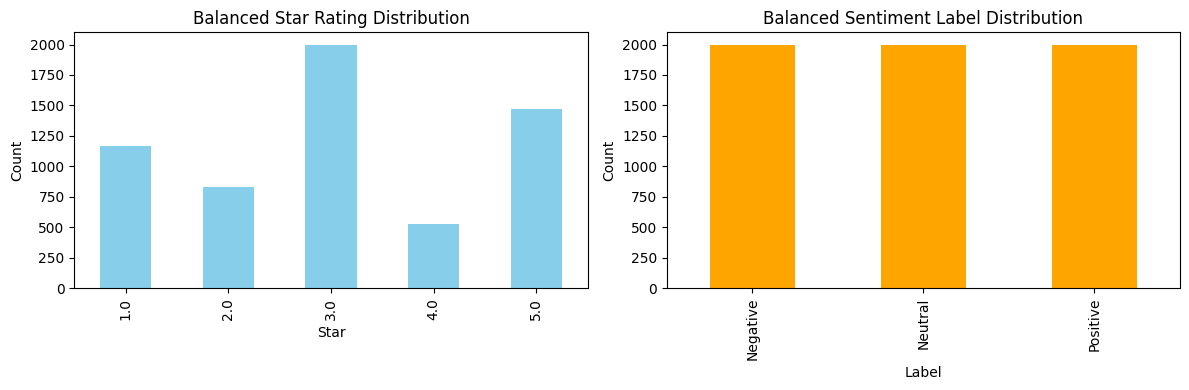

In [9]:
# Check distribution in balanced dataset
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Star Rating Distribution (from overall column)
df_bal[rating_col].value_counts().sort_index().plot(
    kind="bar", color="skyblue", ax=axes[0]
)
axes[0].set_title("Balanced Star Rating Distribution")
axes[0].set_xlabel("Star")
axes[0].set_ylabel("Count")

# Sentiment Label Distribution (from label column)
df_bal["label"].value_counts().reindex(
    ["Negative", "Neutral", "Positive"]
).plot(kind="bar", color="orange", ax=axes[1])
axes[1].set_title("Balanced Sentiment Label Distribution")
axes[1].set_xlabel("Label")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

In [6]:
def map_labels(df, mapping_type="current"):
    if mapping_type == "current":
        # Current: 1–2 = Negative, 3 = Neutral, 4–5 = Positive
        def star_to_label(x):
            if x in (1, 2): return "Negative"
            if x == 3: return "Neutral"
            if x in (4, 5): return "Positive"
            return None
    else:
        # Alternative: 1 = Negative, 2–3 = Neutral, 4–5 = Positive
        def star_to_label(x):
            if x == 1: return "Negative"
            if x in (2, 3): return "Neutral"
            if x in (4, 5): return "Positive"
            return None

    df_copy = df[[rating_col, text_col, title_col, pid_col]].copy()
    df_copy["label"] = df_copy[rating_col].apply(star_to_label)
    df_copy = df_copy.dropna(subset=[text_col, "label"]).reset_index(drop=True)
    return df_copy


# Apply both mappings
df_current = map_labels(df_raw, mapping_type="current")
df_alternative = map_labels(df_raw, mapping_type="alternative")

print("Current mapping distribution:")
print(df_current["label"].value_counts(), "\n")

print("Alternative mapping distribution:")
print(df_alternative["label"].value_counts())

Current mapping distribution:
label
Positive    97315
Negative    13339
Neutral      9346
Name: count, dtype: int64 

Alternative mapping distribution:
label
Positive    97315
Neutral     14928
Negative     7757
Name: count, dtype: int64


In [7]:
def balance_classes(df, target_per_class=2000, random_state=42):
    balanced_parts = []
    for cls in ["Negative", "Neutral", "Positive"]:
        cls_df = df[df["label"] == cls]
        take_n = min(target_per_class, len(cls_df))
        balanced_parts.append(cls_df.sample(n=take_n, random_state=random_state))
    return pd.concat(balanced_parts, axis=0).sample(frac=1, random_state=random_state).reset_index(drop=True)

df_bal_current = balance_classes(df_current)
df_bal_alternative = balance_classes(df_alternative)

print("Current mapping balanced:", df_bal_current["label"].value_counts())
print("Alternative mapping balanced:", df_bal_alternative["label"].value_counts())

Current mapping balanced: label
Negative    2000
Neutral     2000
Positive    2000
Name: count, dtype: int64
Alternative mapping balanced: label
Negative    2000
Neutral     2000
Positive    2000
Name: count, dtype: int64


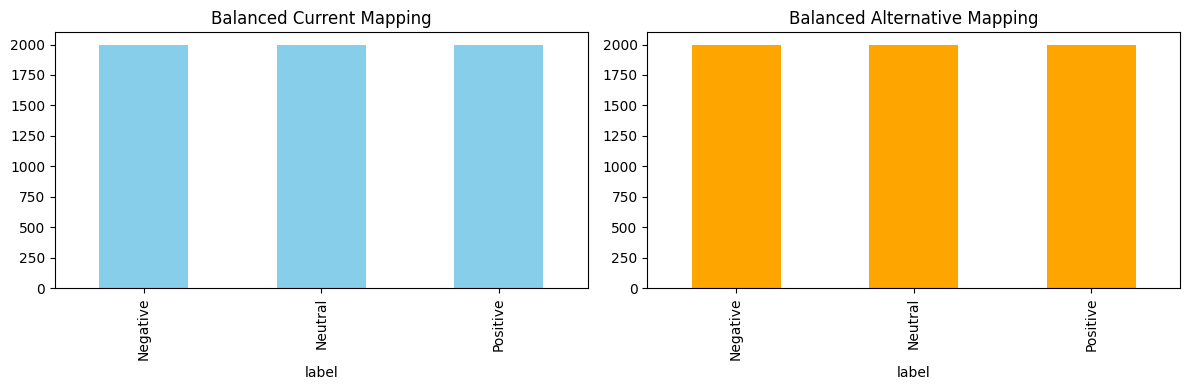

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))

df_bal_current["label"].value_counts().plot(kind="bar", color="skyblue", ax=axes[0])
axes[0].set_title("Balanced Current Mapping")

df_bal_alternative["label"].value_counts().plot(kind="bar", color="orange", ax=axes[1])
axes[1].set_title("Balanced Alternative Mapping")

plt.tight_layout()
plt.show()

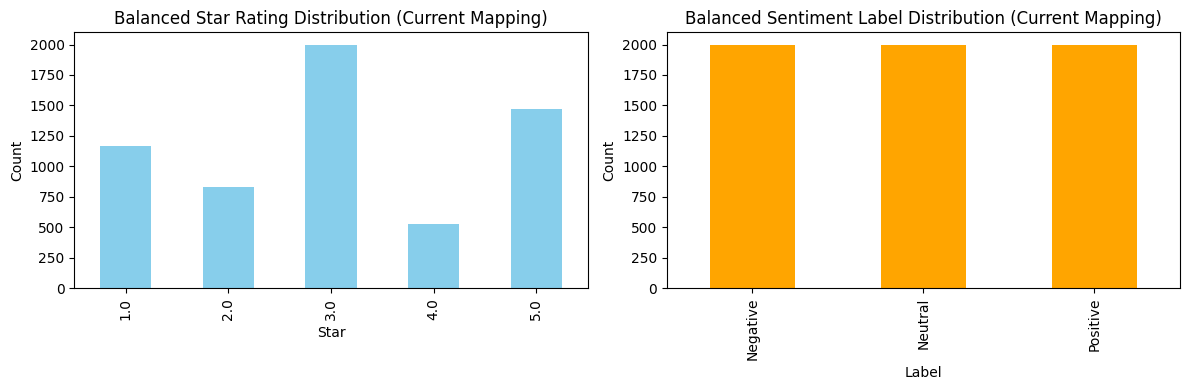

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))

# Balanced Star Rating Distribution
df_bal_current[rating_col].value_counts().sort_index().plot(kind="bar", color="skyblue", ax=axes[0])
axes[0].set_title("Balanced Star Rating Distribution (Current Mapping)")
axes[0].set_xlabel("Star")
axes[0].set_ylabel("Count")

# Balanced Sentiment Distribution
df_bal_current["label"].value_counts().reindex(["Negative","Neutral","Positive"]).plot(
    kind="bar", color="orange", ax=axes[1]
)
axes[1].set_title("Balanced Sentiment Label Distribution (Current Mapping)")
axes[1].set_xlabel("Label")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

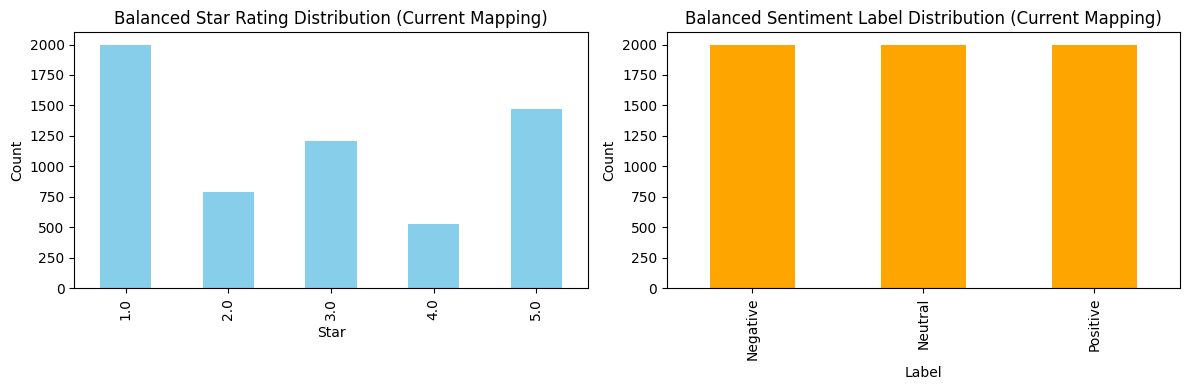

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))

# Balanced Star Rating Distribution
df_bal_alternative[rating_col].value_counts().sort_index().plot(kind="bar", color="skyblue", ax=axes[0])
axes[0].set_title("Balanced Star Rating Distribution (Current Mapping)")
axes[0].set_xlabel("Star")
axes[0].set_ylabel("Count")

# Balanced Sentiment Distribution
df_bal_alternative["label"].value_counts().reindex(["Negative","Neutral","Positive"]).plot(
    kind="bar", color="orange", ax=axes[1]
)
axes[1].set_title("Balanced Sentiment Label Distribution (Current Mapping)")
axes[1].set_xlabel("Label")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# **Task 2: (Model for Review Classification)**

# Train Test Split

In [17]:
# Define features and labels
X = df_bal["reviewText"].values
y = df_bal["label"].values

# First split: train vs temp (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Second split: validation vs test (50/50 of the temp set)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))

Train size: 4200
Validation size: 900
Test size: 900


# Token length Check

In [18]:
MODEL_NAME = "roberta-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def token_lens(texts, sample_n=1000):
    rng = np.random.default_rng(42)
    idx = np.arange(len(texts))
    if len(idx) > sample_n:
        idx = rng.choice(idx, size=sample_n, replace=False)
    sample = [str(texts[i]) for i in idx]
    return [len(tokenizer.encode(t, truncation=False)) for t in sample]

lens = token_lens(X_train)
p95 = int(np.percentile(lens, 95))
p99 = int(np.percentile(lens, 99))

MAX_LEN = min(384, p95)

MAX_LEN, p95, p99

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1420 > 512). Running this sequence through the model will result in indexing errors


(384, 435, 865)

# Tokenization

In [28]:
MODEL_NAME = "roberta-base"
MAX_LEN = 384

df_text = df_bal[["summary", "reviewText", "label"]].copy()
df_text["summary"] = df_text["summary"].fillna("").str.strip()
df_text["reviewText"] = df_text["reviewText"].fillna("").str.strip()
df_text["text"] = (
    df_text["summary"].where(df_text["summary"].ne(""), "[no summary]")
    + " [SEP] "
    + df_text["reviewText"]
)

X = df_text["text"].values
y = df_text["label"].values

# Split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))

# Label maps
label2id = {"Negative": 0, "Neutral": 1, "Positive": 2}
id2label = {v: k for k, v in label2id.items()}

# Pandas
import pandas as pd
train_df = pd.DataFrame({"text": X_train, "label": [label2id[y] for y in y_train]})
val_df   = pd.DataFrame({"text": X_val,   "label": [label2id[y] for y in y_val]})
test_df  = pd.DataFrame({"text": X_test,  "label": [label2id[y] for y in y_test]})

ds_train = Dataset.from_pandas(train_df, preserve_index=False)
ds_val   = Dataset.from_pandas(val_df,   preserve_index=False)
ds_test  = Dataset.from_pandas(test_df,  preserve_index=False)

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

def tok_fn(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN,
    )

# Tokenize all splits
tok_train = ds_train.map(tok_fn, batched=True, remove_columns=["text"])
tok_val   = ds_val.map(tok_fn,   batched=True, remove_columns=["text"])
tok_test  = ds_test.map(tok_fn,  batched=True, remove_columns=["text"])

# Torch format
tok_train = tok_train.with_format("torch", columns=["input_ids", "attention_mask", "label"])
tok_val   = tok_val.with_format("torch",   columns=["input_ids", "attention_mask", "label"])
tok_test  = tok_test.with_format("torch",  columns=["input_ids", "attention_mask", "label"])

Train size: 4200
Validation size: 900
Test size: 900


Map:   0%|          | 0/4200 [00:00<?, ? examples/s]

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

# Model Training

In [35]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3,
    id2label=id2label,
    label2id=label2id,
)

# metrics
acc = evaluate.load("accuracy")
f1  = evaluate.load("f1")

def compute_metrics(p):
    preds = p.predictions.argmax(axis=-1)
    return {
        "accuracy":    acc.compute(predictions=preds, references=p.label_ids)["accuracy"],
        "f1_weighted": f1.compute(predictions=preds, references=p.label_ids, average="weighted")["f1"],
    }

# class weights
y_train_ids   = np.array([label2id[y] for y in y_train])
class_counts  = np.bincount(y_train_ids, minlength=3)
class_weights = class_counts.sum() / (class_counts * 3.0)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# custom trainer: weighted CE + label smoothing
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        if labels.dtype != torch.long:
            labels = labels.long()

        outputs = model(**inputs)
        logits  = outputs.get("logits")

        # label smoothing
        eps = 0.05
        num_labels = logits.size(-1)
        with torch.no_grad():
            true_dist = torch.zeros_like(logits).scatter_(1, labels.unsqueeze(1), 1.0)
            true_dist = (1.0 - eps) * true_dist + eps / num_labels

        # weighted cross-entropy on smoothed targets
        log_probs = torch.log_softmax(logits, dim=-1)
        w = class_weights.to(log_probs.device)
        loss_per_class = -(true_dist * log_probs)
        loss = (loss_per_class * w.unsqueeze(0)).sum(dim=-1).mean()

        return (loss, outputs) if return_outputs else loss

# Hyperparameters
EPOCHS   = 3
LR       = 2e-5
BS       = 16
PATIENCE = 1

training_args = TrainingArguments(
    output_dir="runs/roberta-sentiment",
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",

    load_best_model_at_end=True,
    metric_for_best_model="f1_weighted",
    greater_is_better=True,

    num_train_epochs=EPOCHS,
    learning_rate=LR,
    weight_decay=0.01,
    warmup_ratio=0.1,

    per_device_train_batch_size=BS,
    per_device_eval_batch_size=BS,
    gradient_accumulation_steps=1,
    group_by_length=True,

    fp16=torch.cuda.is_available(),
    report_to=[],
    seed=42,
)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tok_train,
    eval_dataset=tok_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=PATIENCE)],
)

trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-84592726.py:81: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted
1,0.865500,0.652928,0.747778,0.740590
2,0.568500,0.603026,0.791111,0.793728
3,0.440300,0.638674,0.793333,0.796810
4,0.344200,0.744361,0.783333,0.784018


TrainOutput(global_step=1052, training_loss=0.554622845957941, metrics={'train_runtime': 496.0672, 'train_samples_per_second': 42.333, 'train_steps_per_second': 2.651, 'total_flos': 3315229063372800.0, 'train_loss': 0.554622845957941, 'epoch': 4.0})

# Model Evaluation

In [36]:
test_metrics = trainer.evaluate(tok_test)
print("Test metrics:", test_metrics)

# Raw predictions
pred = trainer.predict(tok_test)
logits = pred.predictions
y_true = pred.label_ids
y_pred = logits.argmax(axis=-1)

print(classification_report(y_true, y_pred, target_names=["Negative","Neutral","Positive"], digits=2))


Test metrics: {'eval_loss': 0.6918296217918396, 'eval_accuracy': 0.7544444444444445, 'eval_f1_weighted': 0.7567206095913166, 'eval_runtime': 4.4029, 'eval_samples_per_second': 204.41, 'eval_steps_per_second': 12.946, 'epoch': 4.0}
              precision    recall  f1-score   support

    Negative       0.79      0.73      0.76       300
     Neutral       0.63      0.71      0.67       300
    Positive       0.86      0.83      0.85       300

    accuracy                           0.75       900
   macro avg       0.76      0.75      0.76       900
weighted avg       0.76      0.75      0.76       900



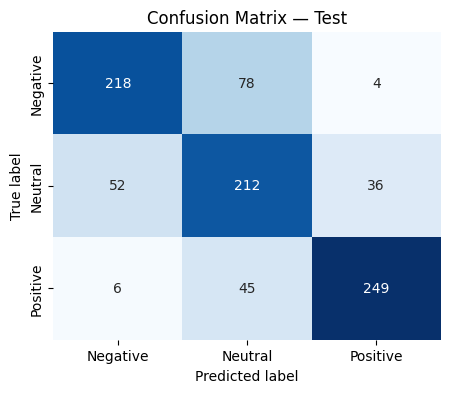

In [37]:
cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
plt.figure(figsize=(5,4))
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
ax.set_xlabel("Predicted label"); ax.set_ylabel("True label")
ax.set_xticklabels(["Negative","Neutral","Positive"])
ax.set_yticklabels(["Negative","Neutral","Positive"])
plt.title("Confusion Matrix — Test"); plt.show()

#Save Model

In [38]:
# save path
save_dir = "/content/roberta_sentiment_v1"

# Save model, tokenizer, trainer state
trainer.save_model(save_dir)
tokenizer.save_pretrained(save_dir)
trainer.save_state()

# Save label maps
import os, json
os.makedirs(save_dir, exist_ok=True)
with open(f"{save_dir}/label_map.json", "w") as f:
    json.dump({"id2label": id2label, "label2id": label2id}, f)

print("Model saved locally at:", save_dir)

# Copy to Drive
from google.colab import drive
drive.mount("/content/drive")

!mkdir -p "/content/drive/MyDrive/NLP_Project_3/checkpoints"
!cp -r {save_dir} "/content/drive/MyDrive/NLP_Project_3/checkpoints/"

print("Model copied to Drive at: /content/drive/MyDrive/NLP_Project_3/checkpoints/")


Model saved locally at: /content/roberta_sentiment_v1
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model copied to Drive at: /content/drive/MyDrive/NLP_Project_3/checkpoints/


# **Task 3: Clustering Model**

In [8]:
def clean_text(t: str) -> str:
    t = str(t).lower()
    t = re.sub(r"http\S+|www\.\S+", " ", t)
    t = re.sub(r"[^a-z0-9\s]", " ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

texts_clean = [clean_text(t) for t in df_bal["reviewText"].astype(str).tolist()]

CLUSTERS = {
    "headphones_audio": [
        "headphone","earbud","earbuds","earphone","earphones","audio","sound",
        "mic","microphone","noise","anc","volume","bass","treble","wireless","bluetooth"
    ],
    "mobile_devices": [
        "phone","iphone","android","pixel","samsung","tablet","ipad","kindle","ereader",
        "screen","display","charger","charging","battery life","case","cover","protector"
    ],
    "laptop_computing": [
        "laptop","macbook","notebook","chromebook","keyboard","mouse","trackpad",
        "monitor","usb","hdmi","ssd","ram","cpu","gpu","dock","docking","hub","adapter"
    ],
    "photo_video": [
        "camera","canon","nikon","dslr","lens","tripod","macro","zoom","photography",
        "projector","display","screen","video","hd","focus","filter","cf card","memory card"
    ],
    "power_storage": [
        "battery","aa","aaa","rechargeable","power bank","powerbank","portable charger",
        "charger","charging","mah","duracell","energizer","anker",
        "outlet","socket","plug","extension","cable","storage","hard drive","ssd","flash drive"
    ]
}

# Assign function
def assign_category(text: str) -> str:
    t = text
    best_cat = None
    best_hits = 0
    for cat, kws in CLUSTERS.items():
        hits = 0
        for kw in kws:
            hits += len(re.findall(rf"\b{re.escape(kw)}\b", t))
        if hits > best_hits:
            best_hits = hits
            best_cat = cat
    return best_cat if best_hits > 0 else "other"

# Apply categorization
df_bal["category"] = [assign_category(t) for t in texts_clean]

# Check distribution
print(df_bal["category"].value_counts())

category
other               1694
headphones_audio    1352
photo_video         1150
laptop_computing     660
power_storage        628
mobile_devices       516
Name: count, dtype: int64


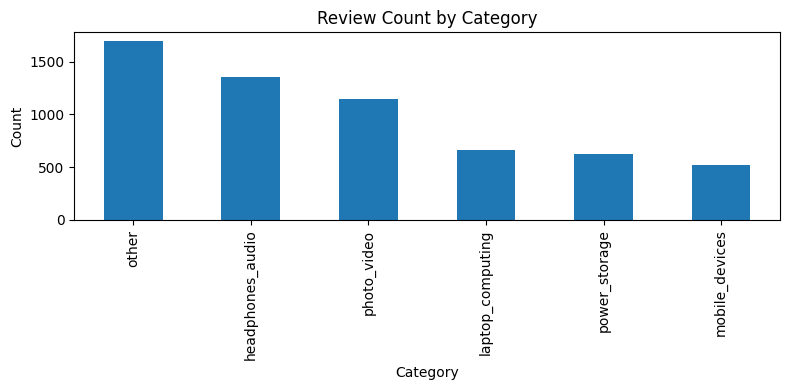

In [11]:
ax = df_bal["category"].value_counts().plot(kind="bar", figsize=(8,4))
ax.set_title("Review Count by Category")
ax.set_xlabel("Category"); ax.set_ylabel("Count")
plt.tight_layout(); plt.show()

# **Task 4: Model Summarization**

In [17]:
# Reproducibility (seed)
SEED = 42
rng = np.random.default_rng(SEED)

# Load pretrained model
DEVICE = 0 if torch.cuda.is_available() else -1
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")
model     = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn")

summarizer = pipeline(
    "summarization",
    model=model,
    tokenizer=tokenizer,
    device=DEVICE
)

# Categories to summarize
CATEGORIES = [
    "headphones_audio",
    "photo_video",
    "laptop_computing",
    "power_storage",
    "mobile_devices",
    "other"
]

# Helper: build a corpus per category
def build_corpus(df: pd.DataFrame, category: str, max_reviews=400, max_chars=40_000) -> str:
    """
    Collect a sample of reviews for the category.
    Concatenate until ~max_chars to keep things fast and within model limits.
    """
    texts = df.loc[df["category"] == category, "reviewText"].astype(str).tolist()
    # sample if too many reviews
    if len(texts) > max_reviews:
        idx = rng.choice(len(texts), size=max_reviews, replace=False)
        texts = [texts[i] for i in idx]

    out, total = [], 0
    for t in texts:
        if total + len(t) > max_chars:
            break
        out.append(t)
        total += len(t)
    return "\n".join(out)

# Helper: summarize long text via chunking
def summarize_text(text: str, in_tokens=256, out_tokens=128) -> str:
    """
    Split long text into chunks (~4 chars per token),
    summarize each chunk, then summarize the stitched partials.
    """
    if not text or len(text) < 600:
        return "Not enough text to summarize."

    # chunk by approx chars-per-token
    chunk_chars = in_tokens * 4
    chunks = [text[i:i+chunk_chars] for i in range(0, len(text), chunk_chars)]
    # cap number of chunks
    chunks = chunks[:8]

    # first pass: summarize chunks
    parts = summarizer(
        chunks,
        truncation=True,
        max_length=out_tokens,
        min_length=max(40, out_tokens // 3),
        do_sample=False
    )
    stitched = " ".join(p["summary_text"] for p in parts)

    # second pass: summarize stitched text
    final = summarizer(
        stitched,
        truncation=True,
        max_length=out_tokens,
        min_length=max(60, out_tokens // 2),
        do_sample=False
    )[0]["summary_text"]

    return final.strip()

# Generate summaries for all categories
summaries = {}
for cat in CATEGORIES:
    corpus = build_corpus(df_bal, cat, max_reviews=400, max_chars=40_000)
    summaries[cat] = summarize_text(corpus, in_tokens=256, out_tokens=128)

# Preview & Save
for cat, s in summaries.items():
    print(f"\n {cat.upper()} — Summary\n{s}\n")

sum_df = pd.DataFrame([{"category": k, "summary": v} for k, v in summaries.items()])\
         .sort_values("category")
sum_df.to_csv("category_summaries.csv", index=False)
sum_df.to_json("category_summaries.json", orient="records", indent=2)
print("Saved: category_summaries.csv, category_summaries.json")

Device set to use cuda:0
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



 HEADPHONES_AUDIO — Summary
The sound is tinny, even with the amplifier on. With only .15 watts per channel, you get volume only marginally above that of a typical set of headphones. For those who need "name" brands like Monster cable, don't bother, the extra 20 bucks a spool is clearly for the name.......no these are horrible. no bass and flat treble. for the money i expected a WHOLE lot more than this.


 PHOTO_VIDEO — Summary
Nikon Action 10x50's seem so much more solid!! The optics are phenomenal - I'm able to see and count surfers in the lineup from miles away. There's absolutely no side-to-side distortion, it's like watching up-close video even though I'm far away on the beach. The brush is soft and I feel comfortable using it on my lenses.


 LAPTOP_COMPUTING — Summary
The Elite is a luxury item I did not come to apprieciate until now. It is incredibly comfortable to the hand and the keys don't break off. The optical mouse includes 2 buttons on the sides, which are customizable

# **Task 5: Model Deployment**

#Setup: mount, paths, load models, helpers

In [29]:
# Mount Drive
drive.mount("/content/drive", force_remount=False)

# Model folder
SAVED_SENTIMENT_DIR = "/content/drive/MyDrive/NLP_Project_3/checkpoints/roberta_base_v1"

# 3) Load label map
with open(Path(SAVED_SENTIMENT_DIR) / "label_map.json", "r") as f:
    label_map = json.load(f)
id2label = {int(k): v for k, v in label_map["id2label"].items()}

# 4) Load tokenizer + model
sent_tok   = AutoTokenizer.from_pretrained(SAVED_SENTIMENT_DIR, local_files_only=True)
sent_model = AutoModelForSequenceClassification.from_pretrained(SAVED_SENTIMENT_DIR, local_files_only=True)

DEVICE = 0 if torch.cuda.is_available() else -1
sentiment = pipeline("text-classification", model=sent_model, tokenizer=sent_tok, device=DEVICE, return_all_scores=False)

# Category keywords
CLUSTERS = {
    "headphones_audio": [
        "headphone","headphones","earbud","earbuds","earphone","earphones",
        "audio","sound","mic","microphone","noise","anc","bluetooth","stereo","headset"
    ],
    "photo_video": [
        "camera","lens","canon","nikon","sony a","tripod","filter","dslr","mirrorless",
        "gopro","camcorder","flash","sd card","memory card","photo","video"
    ],
    "laptop_computing": [
        "laptop","macbook","notebook","chromebook","keyboard","mouse","monitor",
        "dock","docking","hub","adapter","usb","hdmi","ssd","ram","cpu","gpu"
    ],
    "power_storage": [
        "battery","batteries","rechargeable","power bank","portable charger","aa","aaa",
        "eneloop","mah","charger","charging"
    ],
    "mobile_devices": [
        "phone","iphone","android","pixel","samsung","tablet","ipad","kindle",
        "smartwatch","apple watch","screen protector","case","cover"
    ],
}

def clean_text(t: str) -> str:
    t = str(t).lower()
    t = re.sub(r"http\S+|www\.\S+", " ", t)
    t = re.sub(r"[^a-z0-9\s]", " ", t)
    return re.sub(r"\s+", " ", t).strip()

def assign_category(text: str) -> str:
    t = clean_text(text)
    best_cat, best_hits = None, 0
    for cat, kws in CLUSTERS.items():
        hits = 0
        for kw in kws:
            hits += len(re.findall(rf"\b{re.escape(kw)}\b", t))
        if hits > best_hits:
            best_hits, best_cat = hits, cat
    return best_cat if best_hits > 0 else "other"

# Summarizer
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
sum_tok  = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")
sum_model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn")
summarizer = pipeline("summarization", model=sum_model, tokenizer=sum_tok, device=DEVICE)

def summarize_reviews(texts, max_chars=6000, out_tokens=120):
    blob = " ".join([clean_text(t) for t in texts])[:max_chars]
    if not blob.strip():
        return "Not enough text to summarize."

    # Choose a smaller max_length if the text is short
    input_len = len(blob.split())
    max_len = min(out_tokens, max(10, input_len + 20))

    return summarizer(
        blob,
        max_length=max_len,
        min_length=max(5, max_len // 3),
        truncation=True,
        do_sample=False
    )[0]["summary_text"]

print("Setup OK. GPU:", torch.cuda.is_available())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Device set to use cuda:0
Device set to use cuda:0


Setup OK. GPU: True


# Smoke Tests

In [30]:
sample = "Great build, loud volume and comfy cushions. Battery life is decent. Mic is a bit weak."
print("Sentiment:", sentiment(sample)[0])          # {'label': 'Positive', 'score': ...}
print("Category :", assign_category(sample))       # e.g., 'headphones_audio'
print("Summary  :", summarize_reviews([sample]))   # short summary


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Your max_length is set to 36, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Sentiment: {'label': 'Neutral', 'score': 0.623867928981781}
Category : headphones_audio
Summary  : Great build loud volume and comfy cushions battery life is decent mic is a bit weak.


# Local Model Deployment Demo: Gradio

In [12]:
def predict_one(review: str) -> str:
    """
    Given a single review string, return four fields in a clean Markdown block:
      1) Sentiment (label + confidence)
      2) Category  (keyword rules)
      3) Summary   (BART with smart max_len)
      4) Recommendation (Yes / No / Mixed) with a one-line rationale
    """
    if not review or review.strip() == "":
        return "Please paste a review above."

    # Sentiment Model
    s = sentiment(review)[0]
    sent_label = s.get("label", "N/A")
    sent_conf  = float(s.get("score", 0.0))
    sent_pct   = f"{round(100*sent_conf)}%"

    # Category
    cat = assign_category(review)

    # Summary
    summary = _summarize_one(review)

    # Thresholds
    POS_THR = 0.60   # confident positive
    NEG_THR = 0.60   # confident negative

    if sent_label == "Positive" and sent_conf >= POS_THR:
        rec_tag = "**Recommend**"
        reason  = "Overall positive sentiment with good confidence."
    elif sent_label == "Negative" and sent_conf >= NEG_THR:
        rec_tag = "**Do not recommend**"
        reason  = "Overall negative sentiment with good confidence."
    else:
        rec_tag = "**Mixed / Needs more reviews**"
        reason  = "Sentiment is neutral or confidence is low."

    if cat == "other":
        reason += " Note: this review doesn’t clearly match the main electronics categories."

    # Output
    lines = [
        f"**Sentiment:** {sent_label} ({sent_pct})",
        f"**Category:** {cat}",
        "",
        "**Summary:**",
        summary,
        "",
        f"**Recommendation:** {rec_tag}",
        f"_Rationale:_ {reason}",
    ]
    return "\n".join(lines)

In [13]:
# Gradio UI
THEME = gr.themes.Soft(primary_hue="green", neutral_hue="slate")

APP_TITLE = "Electronics Review Assistant"
APP_DESC = (
    "Analyze customer reviews for consumer electronics:\n\n"
    "• Predicts sentiment with RoBERTa  \n"
    "• Assigns a product category (headphones, laptops, etc.)  \n"
    "• Generates a short summary with BART"
)

EXAMPLES = [
    ["Great build, loud volume and comfy cushions. Battery life is decent, mic is a bit weak."],
    ["The camera quality is solid outdoors, but very grainy in low light."],
    ["Laptop feels sturdy but the trackpad lags and the battery drains too fast."],
]

demo = gr.Interface(
    fn=predict_one,
    inputs=gr.Textbox(
        lines=6,
        label="Enter one electronics review",
        placeholder="Paste an electronics review here…",
    ),
    outputs=gr.Markdown(label="Analysis"),
    title=APP_TITLE,
    description=APP_DESC,
    examples=EXAMPLES,
    theme=THEME,
)

demo.footer = gr.Markdown(
    "Built for **NLP Project** · Electronics reviews · Classification (RoBERTa), Clustering, Summarization (BART)"
)

In [47]:
demo.close()
demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a528fea2c3e0091bf4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# **Top Products per Category**

In [14]:
# Checks
NEEDED_COLS = {"asin", "reviewText", "overall", "category"}
missing = NEEDED_COLS - set(df_bal.columns)
if missing:
    raise ValueError(f"df_bal is missing columns: {missing}")

# helper: to get top complaint terms for a set of reviews
STOP_TERMS = {
    "the","and","this","that","with","for","you","but","are","was","have","has","had",
    "they","them","it","its","my","we","our","your","to","of","in","on","is","as",
    "very","just","really","also","one","two","three","get","got","make","made","may",
    "would","could","should","im","ive","dont","doesnt","cant","wont","didnt","like",
    "good","great","best","love","excellent","awesome","amazing","perfect","nice",
    "okay","ok","well","works","work","working","use","used","using"
}
NEG_HINTS = {"bad","poor","terrible","awful","broke","broken","return","refund",
             "cheap","noisy","quiet","weak","slow","hot","warm","overheat",
             "battery","drain","die","dies","dead","loose","fit","scratch",
             "static","hiss","echo","distort","lag","latency","connect","disconnect",
             "pair","drop","signal","range","short","small","big","heavy","uncomfortable",
             "tight","hurt","ear","mic","microphone","volume","bass","treble","noise",
             "anc","cancel","camera","image","photo","video","blurry","grainy","dark",
             "charge","charger","charging","cable"
}

def top_complaints(texts: list[str], k: int = 5) -> list[str]:
    if not texts:
        return []
    vec = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.8)
    X = vec.fit_transform([t.lower() for t in texts])
    terms = np.array(vec.get_feature_names_out())

    # score
    scores = np.asarray(X.sum(axis=0)).ravel()
    order = scores.argsort()[::-1]

    out = []
    for idx in order:
        term = terms[idx]
        # simple filters: drop stopwords
        if any(w in STOP_TERMS for w in term.split()):
            continue
        if (any(w in NEG_HINTS for w in term.split())) or (" " in term):
            out.append(term)
        if len(out) >= k:
            break
    return out

# Aggregate per product, per category
def build_product_table(df: pd.DataFrame, min_reviews: int = 15) -> pd.DataFrame:
    g = (df
         .groupby(["category","asin"], as_index=False)
         .agg(
             n_reviews=("overall","size"),
             mean_rating=("overall","mean"),
         ))
    g = g[g["n_reviews"] >= min_reviews].copy()

    # score: reward rating
    g["score"] = g["mean_rating"] + 0.15 * np.log1p(g["n_reviews"])
    return g.sort_values(["category","score"], ascending=[True, False])

product_table = build_product_table(df_bal, min_reviews=15)

# Precompute top-3 + worst + complaints
CAT_BROWSER = {}

for cat in sorted(product_table["category"].unique()):
    sub = product_table[product_table["category"] == cat]

    top3 = sub.nlargest(3, "score")
    # “worst”
    worst = sub.nsmallest(1, "mean_rating")

    # gather complaints per product
    rows = []
    for _, row in pd.concat([top3, worst]).drop_duplicates("asin").iterrows():
        asin = row["asin"]
        texts = df_bal.loc[(df_bal["category"]==cat) & (df_bal["asin"]==asin), "reviewText"].astype(str).tolist()
        complaints = top_complaints(texts, k=5)
        rows.append({
            "asin": asin,
            "n_reviews": int(row["n_reviews"]),
            "mean_rating": round(float(row["mean_rating"]), 2),
            "score": round(float(row["score"]), 3),
            "complaints": complaints
        })

    CAT_BROWSER[cat] = {
        "top3": [r for r in rows if r["asin"] in top3["asin"].tolist()],
        "worst": [r for r in rows if r["asin"] in worst["asin"].tolist()][0] if not worst.empty else None
    }

print("Category browser ready with:", list(CAT_BROWSER.keys()))

Category browser ready with: ['headphones_audio', 'laptop_computing', 'other', 'photo_video', 'power_storage']


In [16]:
# Category Markdown
def render_category(cat: str) -> str:
    if not cat or cat not in CAT_BROWSER:
        return "Pick a category to see top products."

    data = CAT_BROWSER[cat]
    lines = [f"## {cat.replace('_',' ').title()} — Top Products"]
    lines.append("Showing products with ≥15 reviews.\n")

    # Top 3
    for i, prod in enumerate(data["top3"], start=1):
        lines += [
            f"**{i}. ASIN:** `{prod['asin']}`  "
            f"**Rating:** {prod['mean_rating']}  "
            f"**Reviews:** {prod['n_reviews']}",
            f"*Frequent complaints:* " + (", ".join(prod["complaints"]) if prod["complaints"] else "—"),
            ""
        ]

    # Worst
    w = data.get("worst")
    if w:
        lines += [
            f"## Worst in Category",
            f"**ASIN:** `{w['asin']}`  **Rating:** {w['mean_rating']}  **Reviews:** {w['n_reviews']}",
            f"*Frequent complaints:* " + (", ".join(w["complaints"]) if w["complaints"] else "—"),
        ]

    return "\n".join(lines)

# 2) UI for browser
cat_ui = gr.Interface(
    fn=render_category,
    inputs=gr.Dropdown(choices=sorted(CAT_BROWSER.keys()), label="Choose a category"),
    outputs=gr.Markdown(label="Products & Issues"),
    title="Browse Categories",
    description="Top-3 products (by rating + volume) and the worst-rated item, with common complaint terms.",
    theme=THEME if "THEME" in globals() else None,
)

# Launch
app = gr.TabbedInterface([demo, cat_ui], ["Single Review", "Category Browser"])
app.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f5bdb05f24d3d336b9.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [18]:
!git status

fatal: not a git repository (or any of the parent directories): .git
